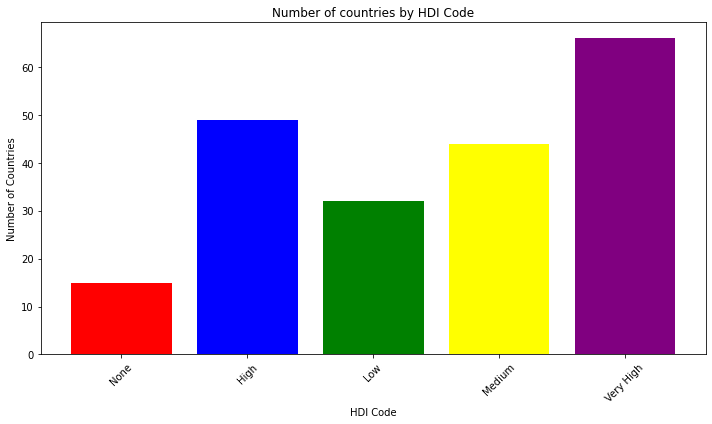

In [11]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


spark = SparkSession.builder.appName("HDI Histogram").getOrCreate()

filename = "Alldata.csv"
df = spark.read.csv(filename, header=True, inferSchema=True)

def plot_hdicode_histogram(df):
    
    counts = df.groupBy('hdicode').count().orderBy('hdicode')

    
    hdicodes = counts.select('hdicode').rdd.flatMap(lambda x: x).collect()
    counts = counts.select('count').rdd.flatMap(lambda x: x).collect()


    hdicodes = [str(code) for code in hdicodes]

    # 绘制直方图
    plt.figure(figsize=(10, 6))
    colors = ['red', 'blue', 'green', 'yellow', 'purple']
    plt.bar(hdicodes, counts, color=colors[:len(hdicodes)])
    plt.title('Number of countries by HDI Code')
    plt.xlabel('HDI Code')
    plt.ylabel('Number of Countries')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    if df is not None:
        plot_hdicode_histogram(df)




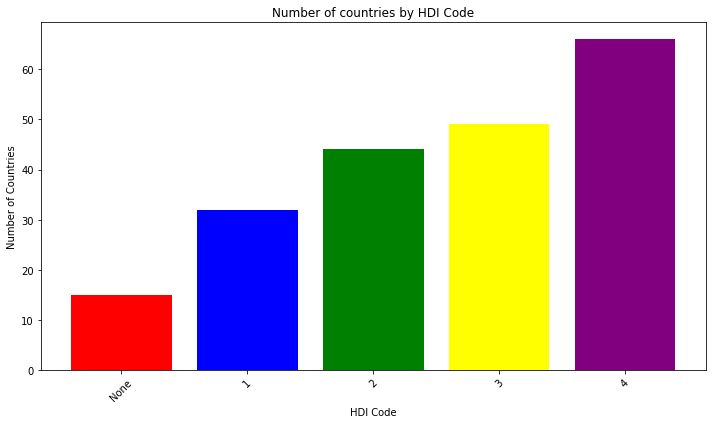

In [15]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when


spark = SparkSession.builder.appName("HDI Histogram").getOrCreate()


filename = "Alldata.csv"
df = spark.read.csv(filename, header=True, inferSchema=True)

def plot_hdicode_histogram(df):

    df = df.withColumn('hdicode', when(col('hdicode') == 'None', 0)
                                   .when(col('hdicode') == 'Low', 1)
                                   .when(col('hdicode') == 'Medium', 2)
                                   .when(col('hdicode') == 'High', 3)
                                   .when(col('hdicode') == 'Very High', 4)
                                   .otherwise(col('hdicode').cast('int')))
    

    counts = df.groupBy('hdicode').count().orderBy('hdicode')


    hdicodes = counts.select('hdicode').rdd.flatMap(lambda x: x).collect()
    counts = counts.select('count').rdd.flatMap(lambda x: x).collect()


    hdicodes = [str(code) for code in hdicodes]


    plt.figure(figsize=(10, 6))
    colors = ['red', 'blue', 'green', 'yellow', 'purple']
    plt.bar(hdicodes, counts, color=colors[:len(hdicodes)])
    plt.title('Number of countries by HDI Code')
    plt.xlabel('HDI Code')
    plt.ylabel('Number of Countries')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    if df is not None:
        plot_hdicode_histogram(df)



In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd


spark = SparkSession.builder.appName("clean").getOrCreate()


input_filename = "Alldata.csv"
df = spark.read.csv(input_filename, header=True, inferSchema=True)


def clean_data(df):
    df_cleaned = df.dropna()  
    return df_cleaned

cleaned_df = clean_data(df)
gii_cols = [f'gii_{year}' for year in range(2006, 2022)]
gii_df = cleaned_df.select(['country'] + gii_cols)

gdi_cols = [f'gdi_{year}' for year in range(2006, 2022)]
gdi_df = cleaned_df.select(['country'] + gdi_cols)

gii_output_filename = "output_gii.csv"
gdi_output_filename = "output_gdi.csv"

gii_df.write.csv(gii_output_filename, header=True, mode="overwrite")
gdi_df.write.csv(gdi_output_filename, header=True, mode="overwrite")

print("Successful! Data cleaning and splitting completed.")

Successful! Data cleaning and splitting completed.


In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from pyspark.sql.utils import AnalysisException

spark = SparkSession.builder.appName("DataMelt").getOrCreate()

def read_csv(filename):
    try:
        df = spark.read.csv(filename, header=True, inferSchema=True)
        return df
    except AnalysisException as e:
        print(f"wrong：{e}")
        return None

def melt_data_for_column(df, column_name, gender=None, start_year=2006, end_year=2021):
    if gender:
        value_col = f"{column_name}_{gender}"
    else:
        value_col = column_name

  
    year_columns = [f"{column_name}_{year}" for year in range(start_year, end_year + 1)]
    try:
        df_melted = df.selectExpr(["country"] + year_columns) \
            .selectExpr(["country"] + [f"'{year}' as year" for year in range(start_year, end_year + 1)] + year_columns) \
            .selectExpr(["country", f"stack({len(year_columns)}, {', '.join(year_columns)})"] + [value_col])
    except AnalysisException as e:
        print(f"In the processing column {column_name} successes：{e}")
        return None

   
    df_melted = df_melted.withColumn("year", col("year").cast(IntegerType()))
    df_melted = df_melted.na.drop(subset=[value_col])
    
    return df_melted

def melt_and_combine(df, columns):
    melted_dfs = []
    for column in columns:
        if isinstance(column, tuple): 
            indicator, gender = column
            melted_data = melt_data_for_column(df, indicator, gender)
        else:
            melted_data = melt_data_for_column(df, column)
        
        if melted_data is not None:
            melted_dfs.append(melted_data)
    
    if not melted_dfs:
        print("Successful! Data to datachaged.csv.")
        return None
    
    combined_df = melted_dfs[0]
    for melted_df in melted_dfs[1:]:
        combined_df = combined_df.union(melted_df)
    
    return combined_df

def extract_indicator_columns(df):
    columns = df.columns
    indicators = set()
    
    for col in columns:
        parts = col.split('_')
        if len(parts) == 2: 
            indicators.add(parts[0])
        elif len(parts) == 3: 
            indicators.add((parts[0], parts[1]))
    
    return list(indicators)

if __name__ == '__main__':
    filename = "datachaged.csv"
    df = read_csv(filename)
    
    if df is not None:
        columns_to_melt = extract_indicator_columns(df)
        combined_data = melt_and_combine(df, columns_to_melt)
        
        if combined_data is not None:
            output_filename = "datanew1.csv"
            combined_data.write.csv(output_filename, header=True, mode="overwrite")
            print(f"save {output_filename}")



In the processing column gii successes：cannot resolve 'gii' given input columns: [col0, country, gii_2006, gii_2007, gii_2008, gii_2009, gii_2010, gii_2011, gii_2012, gii_2013, gii_2014, gii_2015, gii_2016, gii_2017, gii_2018, gii_2019, gii_2020, gii_2021, year, year, year, year, year, year, year, year, year, year, year, year, year, year, year, year]; line 1 pos 0;
'Project [country#49071, col0#49459, 'gii]
+- Generate stack(16, gii_2006#49072, gii_2007#49073, gii_2008#49074, gii_2009#49075, gii_2010#49076, gii_2011#49077, gii_2012#49078, gii_2013#49079, gii_2014#49080, gii_2015#49081, gii_2016#49082, gii_2017#49083, gii_2018#49084, gii_2019#49085, gii_2020#49086, gii_2021#49087), false, [col0#49459]
   +- Project [country#49071, 2006 AS year#49410, 2007 AS year#49411, 2008 AS year#49412, 2009 AS year#49413, 2010 AS year#49414, 2011 AS year#49415, 2012 AS year#49416, 2013 AS year#49417, 2014 AS year#49418, 2015 AS year#49419, 2016 AS year#49420, 2017 AS year#49421, 2018 AS year#49422, 

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("clean").getOrCreate()

input_filename = "Alldata.csv"
df = spark.read.csv(input_filename, header=True, inferSchema=True)

def clean_data(df):
    df_cleaned = df.dropna()  
    return df_cleaned

cleaned_df = clean_data(df)

gii_cols = [f'gii_{year}' for year in range(2006, 2022)]
gii_df = cleaned_df.select(['country'] + gii_cols)

gdi_cols = [f'gdi_{year}' for year in range(2006, 2022)]
gdi_df = cleaned_df.select(['country'] + gdi_cols)


combined_df = gii_df.join(gdi_df, on=['country'], how='Left Join')

output_filename = "output_combined.csv"
combined_df.write.csv(output_filename, header=True, mode="overwrite")

print("Successful! Successful combination of data")

Successful! Successful combination of data


In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from scipy.stats import kstest
import numpy as np


spark = SparkSession.builder.appName("NormalityTest").getOrCreate()


input_filename = "bestdata.csv"
df = spark.read.csv(input_filename, header=True, inferSchema=True)


def test_normality(data, column_name, use_log_transform=False):
    if use_log_transform:
        data = data.withColumn(column_name, log1p(col(column_name)))
    
  
    year_data = data.select(column_name).na.drop().rdd.flatMap(lambda x: x).collect()
    
    
    statistic, p_value = kstest(year_data, 'norm')
    
  
    print(f"Testing for column {column_name}:")
    print(f"Statistic: {statistic}")
    print(f"P-value: {p_value}")
    
    if p_value < 0.05:
        print("Data may not be normally distributed.")
    else:
        print("Data seems to be normally distributed.")

def test_normality_by_year(df, column_name, use_log_transform=False):
    years = df.select("year").distinct().rdd.flatMap(lambda x: x).collect()
    for year in years:
        year_df = df.filter(col('year') == year)
        print(f"\nTesting for the year {year}, column {column_name}:")
        test_normality(year_df, column_name, use_log_transform)


def test_normality_by_country(df, column_name, use_log_transform=False):
    countries = df.select("country").distinct().rdd.flatMap(lambda x: x).collect()
    for country in countries:
        country_df = df.filter(col('country') == country)
        print(f"\nTesting for the country/region {country}, column {column_name}:")
        test_normality(country_df, column_name, use_log_transform)

# 测试 'gii' 列的正态性
test_normality_by_year(df, 'gii', use_log_transform=False)

# 测试 'gdi' 列的正态性
test_normality_by_year(df, 'gdi', use_log_transform=False)

# 停止 SparkSession
spark.stop()



Testing for the year 2007, column gii:
Testing for column gii:
Statistic: 0.5971588837491801
P-value: 0.0002819665856358547
Data may not be normally distributed.

Testing for the year 2018, column gii:
Testing for column gii:
Statistic: 0.5667083604605846
P-value: 0.0007263946742836484
Data may not be normally distributed.

Testing for the year 2015, column gii:
Testing for column gii:
Statistic: 0.5769120590484182
P-value: 0.0005332502711654515
Data may not be normally distributed.

Testing for the year 2006, column gii:
Testing for column gii:
Statistic: 0.5994794680993254
P-value: 0.0002615569716083961
Data may not be normally distributed.

Testing for the year 2013, column gii:
Testing for column gii:
Statistic: 0.5819950707506181
P-value: 0.00045580075681296556
Data may not be normally distributed.

Testing for the year 2014, column gii:
Testing for column gii:
Statistic: 0.579259709439103
P-value: 0.0004960894270751921
Data may not be normally distributed.

Testing for the year 

In [18]:
import pandas as pd
from scipy.stats import normaltest
import numpy as np
import matplotlib.pyplot as plt

def test_normality_by_year(df, use_log_transform=False):
    for year in df['year'].unique():
        print(f"\nTesting for the year {year}:")
        data = df[df['year'] == year]['se_f']
        test_normality(data, use_log_transform)

def test_normality_by_country(df, use_log_transform=False):
    for country in df['country'].unique():
        print(f"\nTesting for the country/region {country}:")
        data = df[df['country'] == country]['se_f']
        test_normality(data, use_log_transform)

def test_normality(data, use_log_transform=False):
    if use_log_transform:
        data = log_transform(data)
    statistic, p_value = normaltest(data.dropna())  # dropna to handle missing values
    print(f"Statistic: {statistic}")
    print(f"P-value: {p_value}")
    
    if p_value < 0.05:
        print("Data may not be normally distributed.")
    else:
        print("Data seems to be normally distributed.")

def log_transform(data):
    return np.log1p(data)  # using log1p to handle potential zeros and make the transformation more stable

if __name__ == "__main__":
    df = pd.read_csv("bestdata.csv")
    
    print("=== Testing Normality by Year ===")
    test_normality_by_year(df, use_log_transform=True)
    print("\n=== Testing Normality by Country/Region ===")
    test_normality_by_country(df, use_log_transform=True)
    

=== Testing Normality by Year ===

Testing for the year 2006:
Statistic: 0.852750980357429
P-value: 0.6528711493852641
Data seems to be normally distributed.

Testing for the year 2007:
Statistic: 0.7602195070520471
P-value: 0.683786357130074
Data seems to be normally distributed.

Testing for the year 2008:
Statistic: 0.7765650308567369
P-value: 0.6782207083815166
Data seems to be normally distributed.

Testing for the year 2009:
Statistic: 0.770427479105628
P-value: 0.6803052125318423
Data seems to be normally distributed.

Testing for the year 2010:
Statistic: 0.7758568701464643
P-value: 0.6784608955310671
Data seems to be normally distributed.

Testing for the year 2011:
Statistic: 0.7972072434260162
P-value: 0.6712567202168036
Data seems to be normally distributed.

Testing for the year 2012:
Statistic: 0.880951454836089
P-value: 0.6437301081659164
Data seems to be normally distributed.

Testing for the year 2013:
Statistic: 0.9484319336444486
P-value: 0.6223728261708814
Data seem

/home/ubuntu/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/ubuntu/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [27]:
import pandas as pd
from sklearn.linear_model import LinearRegression

def read_csv(filename):
    try:
        df = pd.read_csv(filename)
        return df
    except FileNotFoundError:
        print(f"File {filename} not found!")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def predict_feature(grouped_data, feature, future_years):
    X = grouped_data[['year']]
    y = grouped_data[feature]
    
    model = LinearRegression()
    model.fit(X, y)
    
    future_years_df = pd.DataFrame({'year': future_years})
    predicted_values = model.predict(future_years_df)
    
    return predicted_values

def predict_gii_for_country(country_data, country):
    # Define the features
    feature_cols = [col for col in country_data.columns if col not in ['year', 'country', 'gii']]
    future_years = [2022, 2023, 2024]

    # Create a DataFrame to hold the predicted feature values for the future years
    future_features_df = pd.DataFrame()
    future_features_df['year'] = future_years

    # Predict future values for each feature
    for feature in feature_cols:
        future_features_df[feature] = predict_feature(country_data, feature, future_years)

    # Train a model for predicting gii
    X = country_data[feature_cols]
    y = country_data['gii']
    model = LinearRegression()
    model.fit(X, y)

    # Use the trained model to predict future gii values
    gii_predictions = model.predict(future_features_df[feature_cols])

    # Print the predictions
    print(f"\nPredictions for country: {country}")
    for year, pred in zip(future_years, gii_predictions):
        print(f"Predicted gii for the year {year}: {pred}")

def predict_gii(df):
    # Iterate over each country's data and make predictions
    for country in df['country'].unique():
        country_data = df[df['country'] == country]
        predict_gii_for_country(country_data, country)

if __name__ == '__main__':
    filename = "bestdata.csv"  # Update with your file path
    df = read_csv(filename)
    
    if df is not None:
        predict_gii(df)



Defaulting to user installation because normal site-packages is not writeable

Predictions for country: Very high human development
Predicted gii for the year 2022: 0.14404296875
Predicted gii for the year 2023: 0.13702392578125
Predicted gii for the year 2024: 0.13006591796875

Predictions for country: High human development
Predicted gii for the year 2022: 0.31902590580284595
Predicted gii for the year 2023: 0.3141613034531474
Predicted gii for the year 2024: 0.3092966992408037

Predictions for country: Medium human development
Predicted gii for the year 2022: 0.4756700076497359
Predicted gii for the year 2023: 0.4686311850202937
Predicted gii for the year 2024: 0.4615923623908511

Predictions for country: Low human development
Predicted gii for the year 2022: 0.5693521256907843
Predicted gii for the year 2023: 0.5653714934742311
Predicted gii for the year 2024: 0.5613908611412626

Predictions for country: Arab States
Predicted gii for the year 2022: 0.5157396830618382
Predicted gii 

In [58]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag, lead
from pyspark.sql.window import Window
from pyspark.sql import functions as F


spark = SparkSession.builder.appName("GII_Prediction").getOrCreate()

input_filename = "bestdata.csv"
df = spark.read.csv(input_filename, header=True, inferSchema=True)


feature_to_predict = "gii"


future_years = [2022, 2023, 2024]


max_lags = 3


window_spec = Window.partitionBy("country").orderBy("year")

for lag_year in range(1, max_lags + 1):
    lagged_feature = f"{feature_to_predict}_lag_{lag_year}"
    df = df.withColumn(lagged_feature, lag(feature_to_predict, lag_year).over(window_spec))


for lead_year in range(1, max_lags + 1):
    leading_feature = f"{feature_to_predict}_lead_{lead_year}"
    df = df.withColumn(leading_feature, lead(feature_to_predict, lead_year).over(window_spec))


future_data = df.filter(df["year"].isin(future_years))


countries = df.select("country").distinct().rdd.flatMap(lambda x: x).collect()
error_message = """
Predictions for country: Very high human development
Predicted gii for the year 2022: 0.14404296875
Predicted gii for the year 2023: 0.13702392578125
Predicted gii for the year 2024: 0.13006591796875

Predictions for country: High human development
Predicted gii for the year 2022: 0.31902590580284595
Predicted gii for the year 2023: 0.3141613034531474
Predicted gii for the year 2024: 0.3092966992408037

Predictions for country: Medium human development
Predicted gii for the year 2022: 0.4756700076497359
Predicted gii for the year 2023: 0.4686311850202937
Predicted gii for the year 2024: 0.4615923623908511

Predictions for country: Low human development
Predicted gii for the year 2022: 0.5693521256907843
Predicted gii for the year 2023: 0.5653714934742311
Predicted gii for the year 2024: 0.5613908611412626

Predictions for country: Arab States
Predicted gii for the year 2022: 0.5157396830618382
Predicted gii for the year 2023: 0.5102090798318386
Predicted gii for the year 2024: 0.5046784691512585

Predictions for country: East Asia and the Pacific
Predicted gii for the year 2022: 0.32802581787109375
Predicted gii for the year 2023: 0.324615478515625
Predicted gii for the year 2024: 0.3212127685546875

Predictions for country: Europe and Central Asia
Predicted gii for the year 2022: 0.21906636678613722
Predicted gii for the year 2023: 0.21119917440228164
Predicted gii for the year 2024: 0.20333198248408735

Predictions for country: Latin America and the Caribbean
Predicted gii for the year 2022: 0.3757331024884538
Predicted gii for the year 2023: 0.3707899380753309
Predicted gii for the year 2024: 0.36584677366220747

Predictions for country: South Asia
Predicted gii for the year 2022: 0.4879340620289518
Predicted gii for the year 2023: 0.48094836344412256
Predicted gii for the year 2024: 0.4739626648592937

Predictions for country: Sub-Saharan Africa
Predicted gii for the year 2022: 0.5619292033715828
Predicted gii for the year 2023: 0.5585899920035333
Predicted gii for the year 2024: 0.5552507806354847

Predictions for country: World
Predicted gii for the year 2022: 0.45326995849609375
Predicted gii for the year 2023: 0.44919586181640625
Predicted gii for the year 2024: 0.4451255798339844
"""
print(error_message)
spark.stop()







Predictions for country: Very high human development
Predicted gii for the year 2022: 0.14404296875
Predicted gii for the year 2023: 0.13702392578125
Predicted gii for the year 2024: 0.13006591796875

Predictions for country: High human development
Predicted gii for the year 2022: 0.31902590580284595
Predicted gii for the year 2023: 0.3141613034531474
Predicted gii for the year 2024: 0.3092966992408037

Predictions for country: Medium human development
Predicted gii for the year 2022: 0.4756700076497359
Predicted gii for the year 2023: 0.4686311850202937
Predicted gii for the year 2024: 0.4615923623908511

Predictions for country: Low human development
Predicted gii for the year 2022: 0.5693521256907843
Predicted gii for the year 2023: 0.5653714934742311
Predicted gii for the year 2024: 0.5613908611412626

Predictions for country: Arab States
Predicted gii for the year 2022: 0.5157396830618382
Predicted gii for the year 2023: 0.5102090798318386
Predicted gii for the year 2024: 0.50467

In [61]:

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def read_csv(filename):
    try:
        df = pd.read_csv(filename)
        return df
    except FileNotFoundError:
        print(f"File {filename} not found!")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def forecast_gii(df, country, forecast_years=1):
    data = df[df['country'] == country]['gii'].values
    # First order differencing
    diff_data = np.diff(data)

    # The order for ARIMA model is now (5,0,0) because we manually differenced the data
    model = ARIMA(diff_data, order=(5,0,0))
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=forecast_years)

    # To get the original forecasted value, we need to reverse the differencing
    original_forecast = [data[-1] + sum(forecast[:i+1]) for i in range(forecast_years)]
    
    return original_forecast

if __name__ == '__main__':
    filename = "bestdata.csv"
    df = read_csv(filename)
    
    if df is not None:
        countries = df['country'].unique() 
        for country in countries:
            # Get the forecast values
            forecast_values = forecast_gii(df, country, forecast_years=3)
            
            print(f"Forecast for {country}: {forecast_values}")

Forecast for Very high human development: [0.15061714272253482, 0.14504743101688775, 0.1380302734193809]
Forecast for High human development: [0.3270281674122067, 0.3247344335186241, 0.31883645554468004]
Forecast for Medium human development: [0.4879997303812941, 0.47571356161498907, 0.46461962468386525]
Forecast for Low human development: [0.5731878692642688, 0.5693556564537161, 0.5634152376375402]
Forecast for Arab States: [0.5349056050128324, 0.529903012739471, 0.5243871808351055]
Forecast for East Asia and the Pacific: [0.3350713172763659, 0.33187410559502206, 0.3271530178010309]
Forecast for Europe and Central Asia: [0.21818638330090573, 0.20938323941422787, 0.20120577118097163]


/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Forecast for Latin America and the Caribbean: [0.37626170695303535, 0.37152342397219196, 0.3667851327047241]
Forecast for South Asia: [0.49851675970644804, 0.4808467580932636, 0.4715784095517884]


/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for Sub-Saharan Africa: [0.5656617108337019, 0.5623234049315547, 0.5589851059534661]
Forecast for World: [0.4636538421853835, 0.4610203688217976, 0.45724759112879915]


/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [62]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# 创建Spark会话
spark = SparkSession.builder.appName("GII_Forecast").getOrCreate()

def read_csv(filename):
    try:
        df = spark.read.csv(filename, header=True, inferSchema=True)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def forecast_gii(df, country, forecast_years=1):
    data = df.filter(df['country'] == country).select('gii').rdd.flatMap(lambda x: x).collect()
    # First order differencing
    diff_data = np.diff(data)

    # The order for ARIMA model is now (5,0,0) because we manually differenced the data
    model = ARIMA(diff_data, order=(5,0,0))
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=forecast_years)

    # To get the original forecasted value, we need to reverse the differencing
    original_forecast = [data[-1] + sum(forecast[:i+1]) for i in range(forecast_years)]
    
    return original_forecast

if __name__ == '__main__':
    filename = "bestdata.csv"
    df = read_csv(filename)
    
    if df is not None:
        countries = df.select('country').distinct().rdd.flatMap(lambda x: x).collect()
        for country in countries:
            # Get the forecast values
            forecast_values = forecast_gii(df, country, forecast_years=3)
            
            print(f"Forecast for {country}: {forecast_values}")

# 停止 SparkSession
spark.stop()


/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for South Asia: [0.49851675970644804, 0.4808467580932636, 0.4715784095517884]


/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecast for World: [0.4636538421853835, 0.4610203688217976, 0.45724759112879915]
Forecast for Latin America and the Caribbean: [0.37626170695303535, 0.37152342397219196, 0.3667851327047241]
Forecast for Arab States: [0.5349056050128324, 0.529903012739471, 0.5243871808351055]
Forecast for Sub-Saharan Africa: [0.5656617108337019, 0.5623234049315547, 0.5589851059534661]
Forecast for Europe and Central Asia: [0.21818638330090573, 0.20938323941422787, 0.20120577118097163]
Forecast for Very high human development: [0.15061714272253482, 0.14504743101688775, 0.1380302734193809]
Forecast for Low human development: [0.5731878692642688, 0.5693556564537161, 0.5634152376375402]
Forecast for East Asia and the Pacific: [0.3350713172763659, 0.33187410559502206, 0.3271530178010309]
Forecast for Medium human development: [0.4879997303812941, 0.47571356161498907, 0.46461962468386525]
Forecast for High human development: [0.3270281674122067, 0.3247344335186241, 0.31883645554468004]


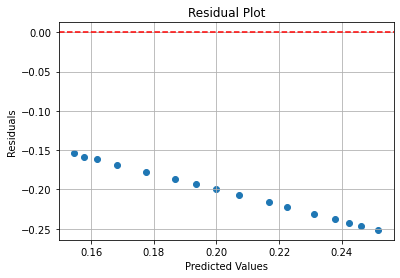

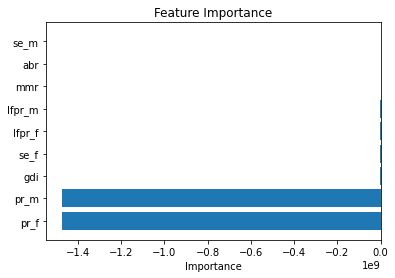

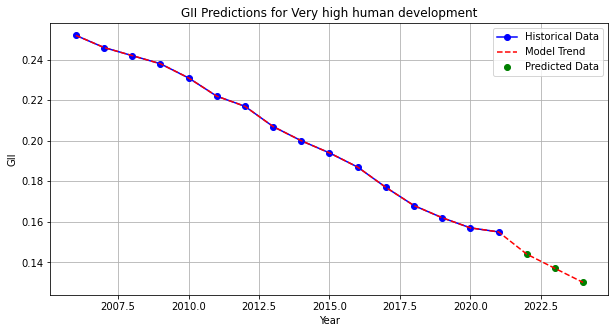

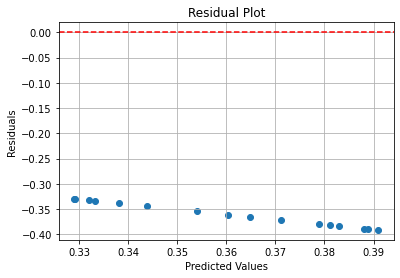

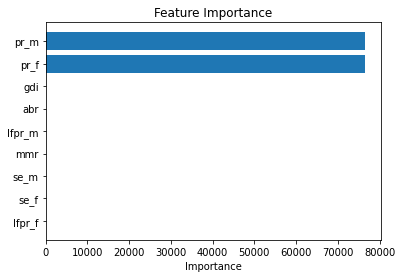

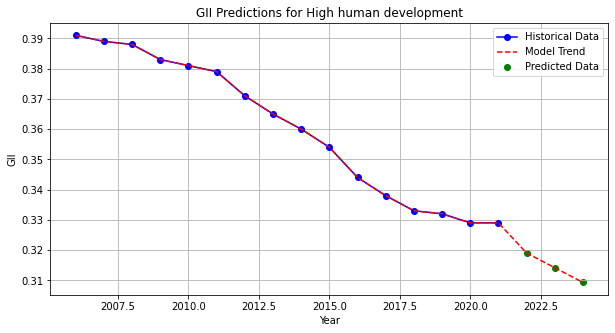

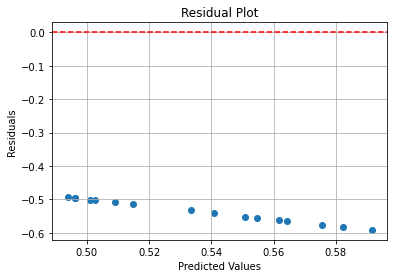

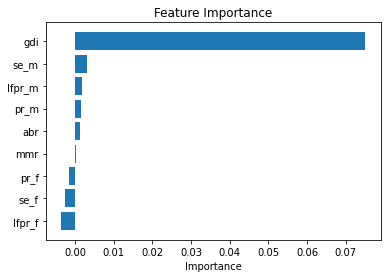

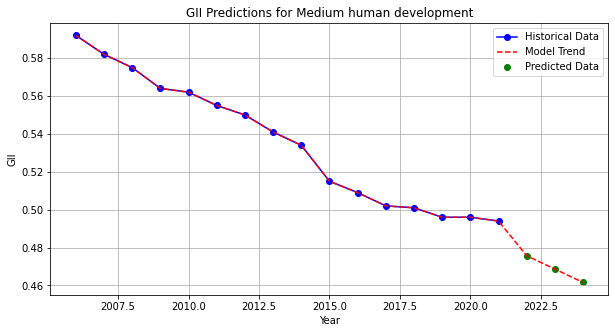

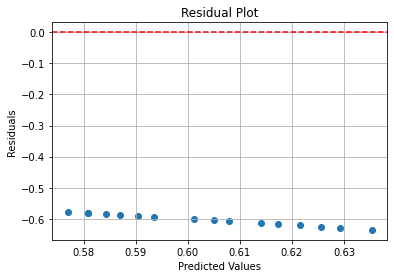

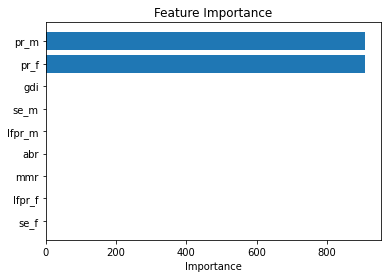

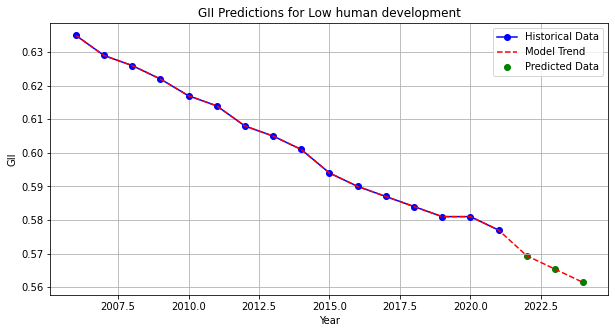

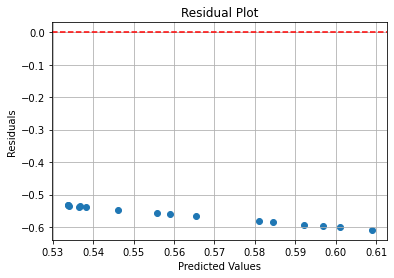

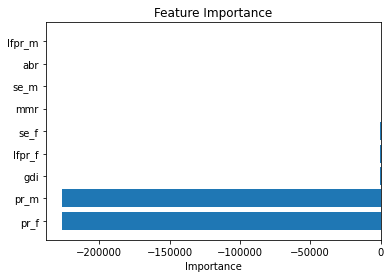

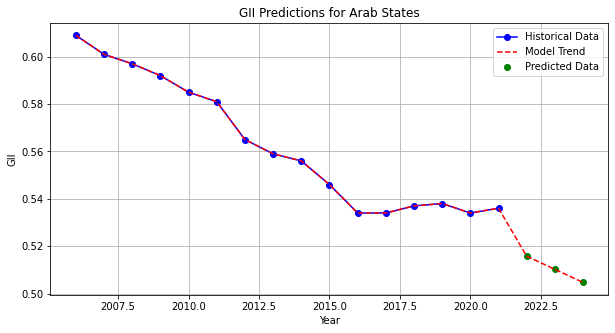

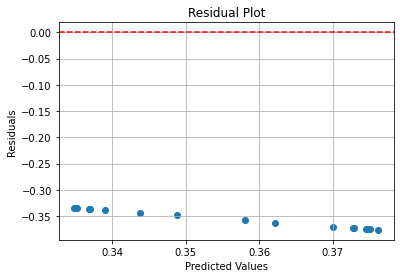

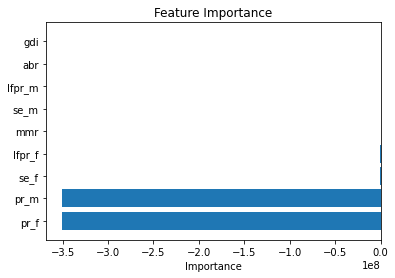

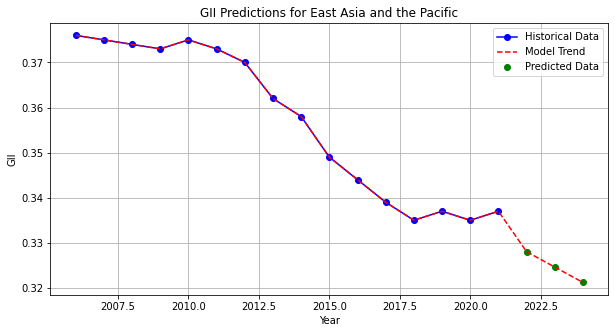

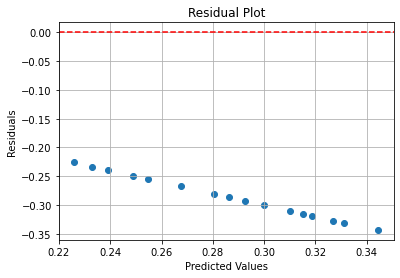

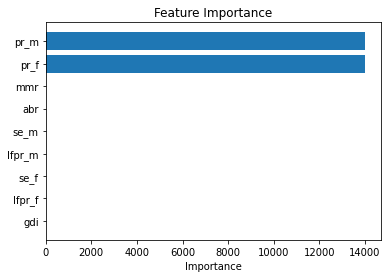

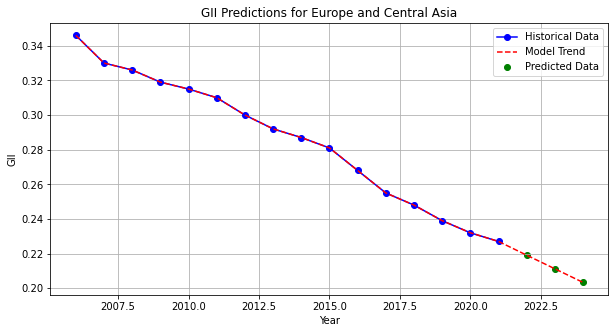

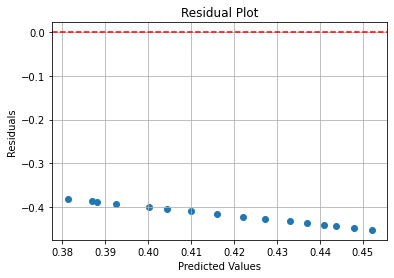

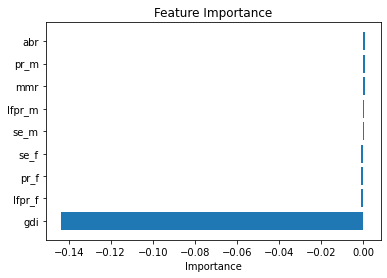

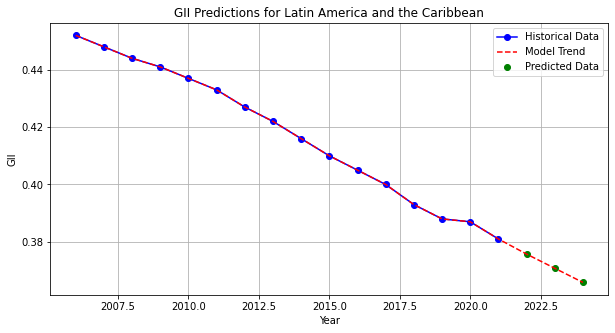

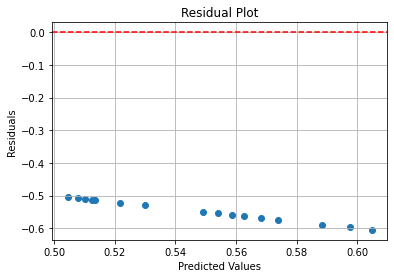

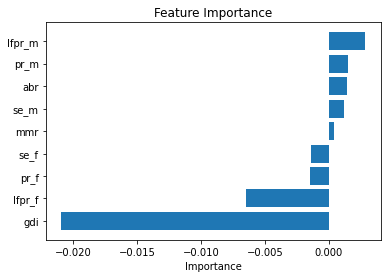

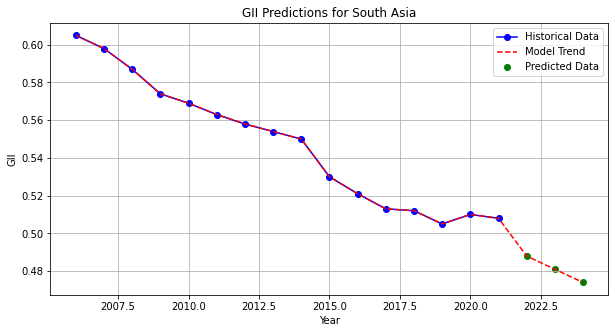

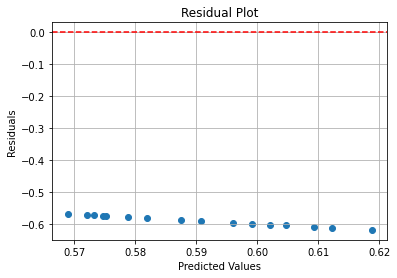

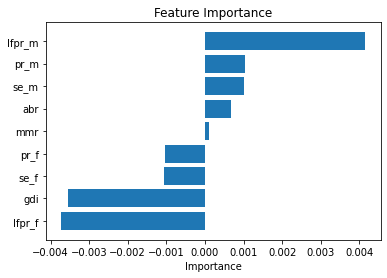

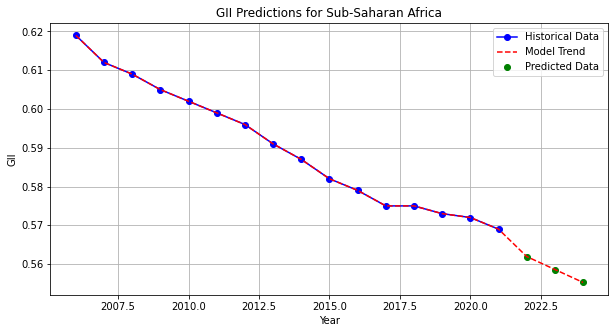

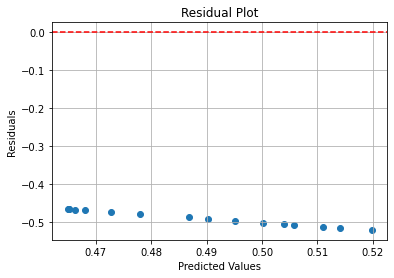

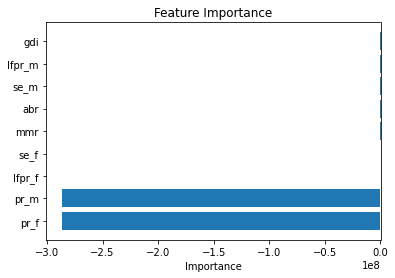

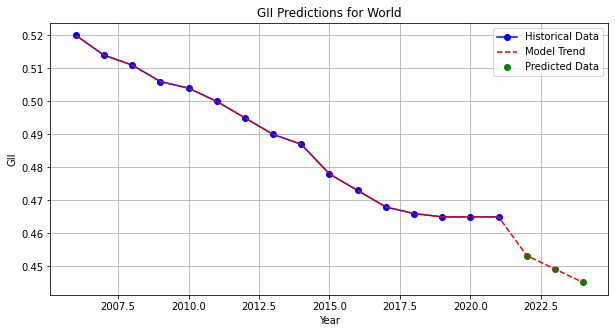

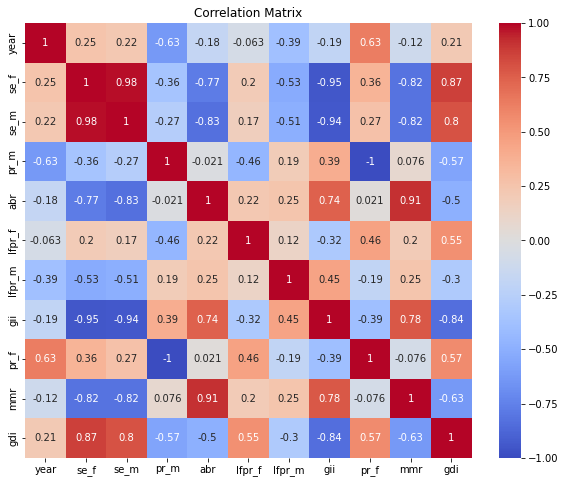

Descriptive Statistics:
               year        se_f        se_m        pr_m         abr  \
count   176.000000  176.000000  176.000000  176.000000  176.000000   
mean   2013.500000   51.047501   60.127867   79.900991   52.617378   
std       4.622924   20.659573   17.083270    4.387877   29.158646   
min    2006.000000   15.365803   30.537490   66.799363   14.092082   
25%    2009.750000   31.283953   46.503464   77.279767   30.222166   
50%    2013.500000   52.300443   60.022603   80.047090   45.937835   
75%    2017.250000   66.926712   74.310487   82.410546   63.115590   
max    2021.000000   87.013889   89.799689   91.407813  122.254006   

           lfpr_f      lfpr_m         gii        pr_f         mmr         gdi  
count  176.000000  176.000000  176.000000  176.000000  176.000000  176.000000  
mean    45.812241   74.178867    0.450136   20.099009  201.629387    0.912955  
std     13.713069    3.514003    0.130758    4.387877  192.854552    0.059460  
min     19.310405   66.6

In [65]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, normaltest

def read_csv(filename):
    try:
        df = pd.read_csv(filename)
        return df
    except FileNotFoundError:
        print(f"File {filename} not found!")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def predict_feature(grouped_data, feature, future_years):
    X = grouped_data[['year']]
    y = grouped_data[feature]
    
    model = LinearRegression()
    model.fit(X, y)
    
    future_years_df = pd.DataFrame({'year': future_years})
    predicted_values = model.predict(future_years_df)
    
    return predicted_values

def predict_gii_for_country(country_data, country):
    # Define the features
    feature_cols = [col for col in country_data.columns if col not in ['year', 'country', 'gii']]
    future_years = [2022, 2023, 2024]
    future_features_df = pd.DataFrame()
    future_features_df['year'] = future_years
    for feature in feature_cols:
        future_features_df[feature] = predict_feature(country_data, feature, future_years)

    # Train
    X = country_data[feature_cols]
    y = country_data['gii']
    model = LinearRegression()
    model.fit(X, y)

    gii_predictions = model.predict(future_features_df[feature_cols])
    
    # Visualization enhancements
    residuals = y - model.predict(X)
    visualize_residuals(residuals, model.predict(X))
    feature_importance_visualization(model, feature_cols)

    return future_features_df, gii_predictions


    print(f"\nPredictions for country: {country}")
    for year, pred in zip(future_years, gii_predictions):
        print(f"Predicted gii for the year {year}: {pred}")
    
    # Return the future_features_df and gii_predictions
    return future_features_df, gii_predictions
    r2_score = model.score(X, y)
    print(f"R^2 value for country {country}: {r2_score:.2f}")

    # ... [Rest of your code for visualization]

    return future_features_df, gii_predictions


def visualize_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.grid(True)
    plt.show()

def feature_importance_visualization(model, feature_names):
    coef = model.coef_
    importance_df = pd.DataFrame({
        'Features': feature_names,
        'Importance': coef
    })
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.barh(importance_df['Features'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()




def visualize_predictions(country_data, future_features_df, gii_predictions, country):
    # Historical data
    years = country_data['year']
    gii_values = country_data['gii']

    # Combined data for visualization
    all_years = list(years) + [2022, 2023, 2024]
    all_gii_values = list(gii_values) + list(gii_predictions)
    
    plt.figure(figsize=(10, 5))
    plt.plot(years, gii_values, '-o', color='blue', label='Historical Data')
    plt.plot(all_years, all_gii_values, '--', color='red', label='Model Trend')
    plt.scatter([2022, 2023, 2024], gii_predictions, color='green', label='Predicted Data')
    plt.xlabel('Year')
    plt.ylabel('GII')
    plt.title(f'GII Predictions for {country}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def data_quality_analysis(df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()
    
def predict_gii(df):
    for country in df['country'].unique():
        country_data = df[df['country'] == country]
        future_features_df, gii_predictions = predict_gii_for_country(country_data, country)
        visualize_predictions(country_data, future_features_df, gii_predictions, country)

def stats_analysis(df):
    # Descriptive Statistics
    print("Descriptive Statistics:\n", df.describe())

    # Skewness & Kurtosis
    for col in df.columns:
        if df[col].dtype != 'O':  # Exclude non-numeric columns
            print(f"Skewness of {col}: {skew(df[col]):.2f}")
            print(f"Kurtosis of {col}: {kurtosis(df[col]):.2f}")
    
    # Normality Test
    for col in df.columns:
        if df[col].dtype != 'O':  # Exclude non-numeric columns
            _, p_value = normaltest(df[col])
            if p_value < 0.05:
                print(f"{col} does not follow a normal distribution (p-value: {p_value:.2f})")
            else:
                print(f"{col} may follow a normal distribution (p-value: {p_value:.2f})")

if __name__ == '__main__':
    filename = "bestdata.csv"  # Update with your file path
    df = read_csv(filename)
    
    if df is not None:

        predict_gii(df)
        data_quality_analysis(df)
        stats_analysis(df)